<a href="https://colab.research.google.com/github/safreitas2000/ml-analytics-mvp/blob/main/MVP_Bert_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-text

In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout
import tensorflow_hub as hub
import tensorflow_text as text

In [13]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/safreitas2000/ml-analytics-mvp/main/McDonald_s_Reviews.csv"

# Lê o arquivo
df = pd.read_csv(url, delimiter=',', encoding='latin-1')
df.head(5)

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star


In [14]:
rat=df.rating.value_counts()
rat

5 stars    10274
1 star      9431
4 stars     5787
3 stars     4818
2 stars     3086
Name: rating, dtype: int64

In [15]:
import matplotlib.pyplot as plt

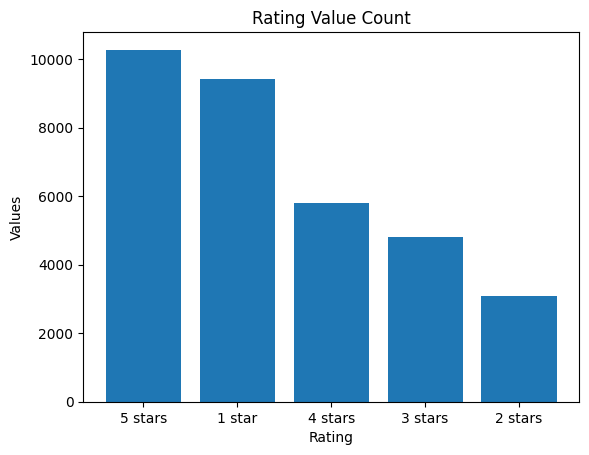

In [16]:
fig, ax = plt.subplots()
ax.bar(rat.index, rat.values)

# Set labels and title
ax.set_xlabel('Rating')
ax.set_ylabel('Values')
ax.set_title('Rating Value Count')

# Display the plot
plt.show()

In [17]:
display(df)

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1 star
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4 stars
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1 star
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5 stars
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1 star
...,...,...,...,...,...,...,...,...,...,...
33391,33392,McDonald's,Fast food restaurant,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",4 years ago,They treated me very badly.,1 star
33392,33393,McDonald's,Fast food restaurant,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",a year ago,The service is very good,5 stars
33393,33394,McDonald's,Fast food restaurant,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",a year ago,To remove hunger is enough,4 stars
33394,33395,McDonald's,Fast food restaurant,"3501 Biscayne Blvd, Miami, FL 33137, United St...",25.810000,-80.189098,"2,810",5 years ago,"It's good, but lately it has become very expen...",5 stars


In [18]:
import re
df["rating"] = df["rating"].str.extract(r"(\d+)", expand=False).astype(int)

In [19]:
df.head(10)

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1
5,6,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 weeks ago,I work for door dash and they locked us all ou...,1
6,7,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,If I could give this location a zero on custo...,1
7,8,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a year ago,Came in and ordered a Large coffee w/no ice. T...,1
8,9,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Went thru drive thru. Ordered. Getting home no...,1
9,10,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,"I'm not really a huge fan of fast food, but I ...",4


In [10]:
#mapping={1:0,2:0,3:None,4:1,5:1}
#df.rating=df.rating.map(mapping)
#df=df.dropna(subset='rating')

In [20]:
df.head(10)

,reviewer_id,store_name,category,store_address,latitude,longitude,rating_count,review_time,review,rating
0,1,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Why does it look like someone spit on my food?...,1
1,2,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,It'd McDonalds. It is what it is as far as the...,4
2,3,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",5 days ago,Made a mobile order got to the speaker and che...,1
3,4,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a month ago,My mc. Crispy chicken sandwich was ï¿½ï¿½ï¿½ï¿...,5
4,5,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",2 months ago,"I repeat my order 3 times in the drive thru, a...",1
5,6,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 weeks ago,I work for door dash and they locked us all ou...,1
6,7,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,If I could give this location a zero on custo...,1
7,8,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",a year ago,Came in and ordered a Large coffee w/no ice. T...,1
8,9,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,Went thru drive thru. Ordered. Getting home no...,1
9,10,McDonald's,Fast food restaurant,"13749 US-183 Hwy, Austin, TX 78750, United States",30.460718,-97.792874,"1,240",3 months ago,"I'm not really a huge fan of fast food, but I ...",4


In [21]:
df["review"] = df["review"].str.encode("ascii", "ignore").str.decode("utf-8")

In [22]:
df = df[["review", "rating"]]

In [23]:
df.head(10)

,review,rating
0,Why does it look like someone spit on my food?...,1
1,It'd McDonalds. It is what it is as far as the...,4
2,Made a mobile order got to the speaker and che...,1
3,My mc. Crispy chicken sandwich was customer s...,5
4,"I repeat my order 3 times in the drive thru, a...",1
5,I work for door dash and they locked us all ou...,1
6,If I could give this location a zero on custo...,1
7,Came in and ordered a Large coffee w/no ice. T...,1
8,Went thru drive thru. Ordered. Getting home no...,1
9,"I'm not really a huge fan of fast food, but I ...",4


In [24]:
X_train, X_test, y_train, y_test = train_test_split(df.review,df.rating,test_size=0.2)

In [25]:
X_train.shape

(26716,)

In [26]:
X_test.shape

(6680,)

In [27]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [28]:
print(df.review[5])

I work for door dash and they locked us all out to wait in a long line for no reason at 10. I tried to beg them to open it because I'm door dash and they refused.  Covid is over get a new job


In [29]:
df.review[1]

"It'd McDonalds. It is what it is as far as the food and atmosphere go. The staff here does make a difference. They are all friendly, accommodating and always smiling. Makes for a more pleasant experience than many other fast food places."

In [30]:
def get_sentense_embeding(sentences):
    preprocesed_text=bert_preprocess(sentences)
    return bert_encoder(preprocesed_text)['pooled_output']
get_sentense_embeding([
    df.review[5],df.review[1]
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8367605 , -0.6208267 , -0.9702623 , ..., -0.8431032 ,
        -0.66128534,  0.9062021 ],
       [-0.6168058 , -0.31054088, -0.91254514, ..., -0.7911302 ,
        -0.5656402 ,  0.80636483]], dtype=float32)>

In [42]:
#O modelo abaixo é adequado para classificação binária
#text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
#preprocessed_text=bert_preprocess(text_input)
#outputs=bert_encoder(preprocessed_text)
#l=tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
#l=tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)
#model=tf.keras.Model(inputs=[text_input],outputs=[l])
# Converta os rótulos de classe em codificação one-hot
y_train_adjusted = y_train - 1
y_train_one_hot = tf.keras.utils.to_categorical(y_train_adjusted, num_classes=5)

#Alterado para considerar as 5 classses:
text_input=tf.keras.layers.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text=bert_preprocess(text_input)
outputs=bert_encoder(preprocessed_text)
l=tf.keras.layers.Dropout(0.1,name='dropout')(outputs['pooled_output'])
l=tf.keras.layers.Dense(5,activation='softmax',name='output')(l)
model=tf.keras.Model(inputs=[text_input],outputs=[l])

In [43]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_mask': (None, 128)   0         ['text[0][0]']                
                             , 'input_word_ids': (None,                                           
                              128),                                                               
                              'input_type_ids': (None,                                            
                             128)}                                                                
                                                                                            

In [44]:
METRICS=[
    #tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)

In [ ]:
model.fit(X_train,y_train_one_hot,epochs=2)

Epoch 1/2
298/835 [=========>....................] - ETA: 2:59 - loss: 0.3628 - precision: 0.7087 - recall: 0.5049

In [ ]:
model.evaluate(X_test,y_test)

In [25]:
y_pred=model.predict(X_test)
y_pred=y_pred.flatten()

179/179 [==============================] - 60s 335ms/step


In [26]:
y_pred=np.where(y_pred>0.5,1,0)
y_pred

array([1, 0, 1, ..., 1, 0, 1])

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
cm=confusion_matrix(y_test,y_pred)

Text(50.722222222222214, 0.5, 'Truth')

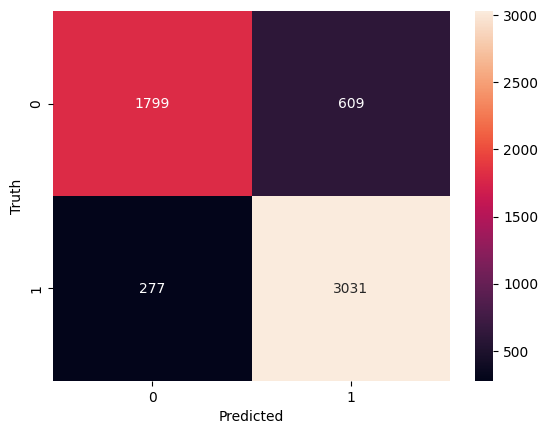

In [29]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.heatmap(cm,annot=True,fmt='d')

plt.xlabel("Predicted")
plt.ylabel("Truth")

In [30]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.75      0.80      2408
         1.0       0.83      0.92      0.87      3308

    accuracy                           0.84      5716
   macro avg       0.85      0.83      0.84      5716
weighted avg       0.85      0.84      0.84      5716



In [31]:
reviews=[df.review[0],df.review[1]

]
model.predict(reviews)

1/1 [==============================] - 1s 987ms/step


array([[0.12754479],
       [0.9361262 ]], dtype=float32)